<a href="https://colab.research.google.com/github/SowmyaDontha88/Machine_Learning/blob/main/Forecast_coco_cola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

# **Problem Statement -> Forecast coco-cola sales**

In [ ]:
data = pd.read_excel('/content/CocaCola_Sales_Rawdata.xlsx')

In [ ]:
data1 = data.copy()

In [ ]:
data.head(3)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [ ]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [ ]:
data.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [ ]:
temp = data.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1')

In [ ]:
data['Month_Year'] = pd.to_datetime(temp).dt.strftime('%b-%Y')

In [ ]:
data.sample(3)

,Quarter,Sales,Month_Year
20,Q1_91,2480.973999,Jan-1991
12,Q1_89,1910.603996,Jan-1989
14,Q3_89,2206.549995,Jul-1989


In [ ]:
data = data.drop(['Quarter'], axis=1)

In [ ]:
data.reset_index(inplace=True)

In [ ]:
data['Month_Year'] = pd.to_datetime(data['Month_Year'])

In [ ]:
data = data.set_index('Month_Year')

In [ ]:
data.head(3)

,index,Sales
Month_Year,,
1986-01-01,0,1734.827000
1986-04-01,1,2244.960999
1986-07-01,2,2533.804993


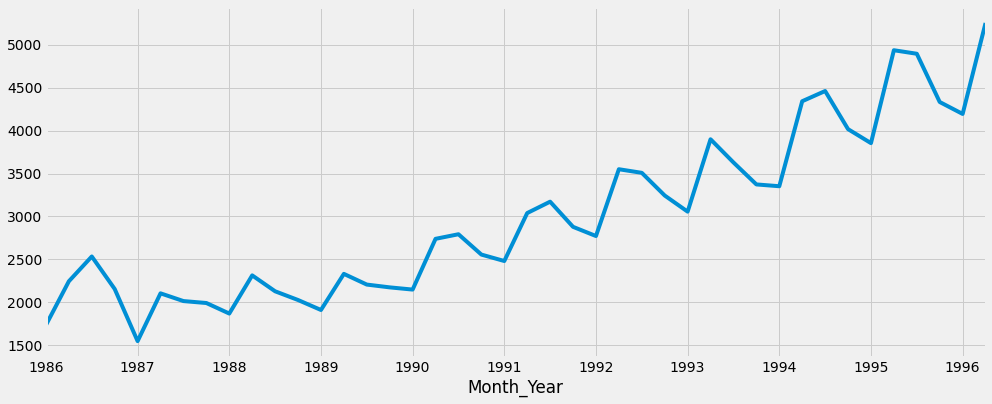

In [ ]:
data['Sales'].plot(figsize=(15, 6))
plt.show()

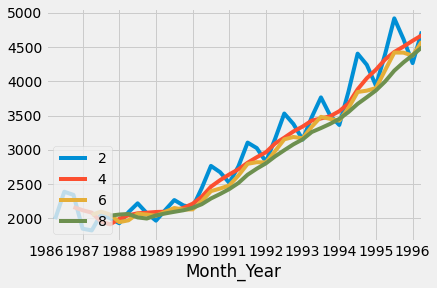

In [ ]:
for i in range(2,10,2):
    data["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

<Figure size 1440x1080 with 0 Axes>

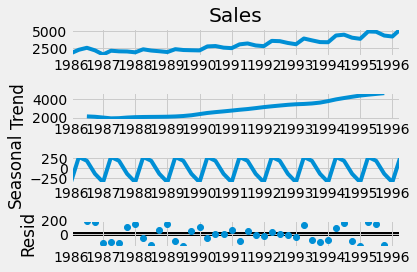

In [ ]:
plt.figure(figsize=(20,15))
ts_add = seasonal_decompose(data.Sales,model="additive")
fig = ts_add.plot()
plt.show()

<Figure size 1440x1080 with 0 Axes>

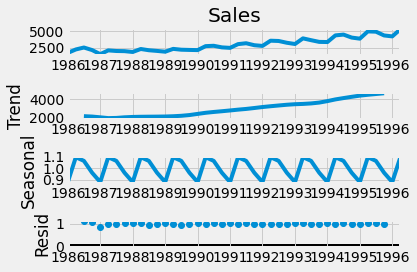

In [ ]:
plt.figure(figsize=(20,15))
ts_mul = seasonal_decompose(data.Sales,model="multiplicative")
fig = ts_mul.plot()
plt.show()

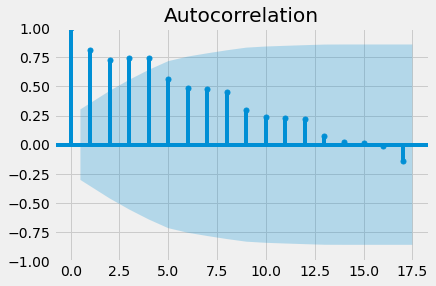

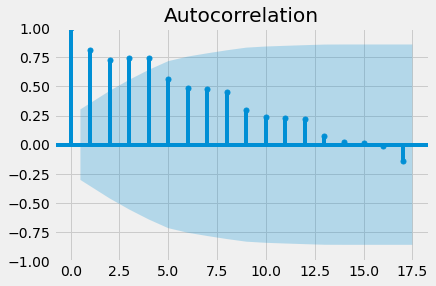

In [ ]:
tsa_plots.plot_acf(data.Sales)

# **Model building ARIMA**

In [ ]:
X = data['Sales'].values

In [ ]:
size = int(len(X) * 0.66)
size

27

In [ ]:
train, test = X[0:size], X[size:len(X)]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
model = ARIMA(train, order=(5,1,0))

In [ ]:
model_fit = model.fit()

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   27
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -174.082
Date:                Mon, 27 Mar 2023   AIC                            360.163
Time:                        10:57:18   BIC                            367.712
Sample:                             0   HQIC                           362.337
                                 - 27                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1024      0.306     -0.335      0.738      -0.702       0.497
ar.L2         -0.2140      0.160     -1.338      0.181      -0.527       0.099
ar.L3         -0.0892      0.191     -0.468      0.640      -0.463       0.284
ar.L4          0.7213      0.131      5.521      0.000       0.465       0.977
ar.L5         -0.1043      0.350     -0.298      0.766      -0.790       0.581
sigma2      2.821e+04   8989.345      3.138      0.002    1.06e+04    4.58e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.93   Prob(JB):                         0.75
Heteroskedasticity (H):               0.38   Skew:                            -0.36
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

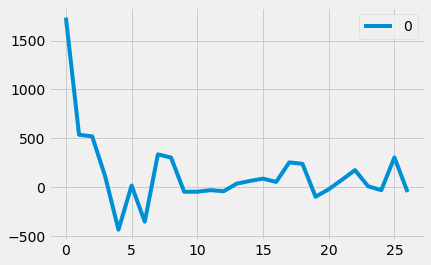

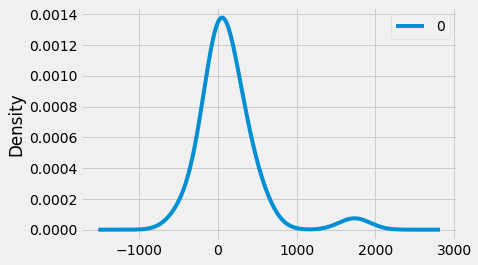

                 0
count    27.000000
mean    137.791854
std     385.970462
min    -433.659591
25%     -34.938856
50%      55.067398
75%     247.080157
max    1734.827000


In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

# **Rolling ARIMA Model**

In [ ]:
history = [x for x in train]

In [ ]:
predictions = list()

In [ ]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=3130.132560, expected=3243.859993
predicted=3167.315971, expected=3056.000000
predicted=3717.472606, expected=3899.000000
predicted=3775.837500, expected=3629.000000
predicted=3332.744953, expected=3373.000000
predicted=3258.575374, expected=3352.000000
predicted=4081.006044, expected=4342.000000
predicted=3955.784129, expected=4461.000000
predicted=4146.277764, expected=4017.000000
predicted=3958.436605, expected=3854.000000
predicted=4701.652928, expected=4936.000000
predicted=4990.071243, expected=4895.000000
predicted=4390.352764, expected=4333.000000
predicted=4190.945470, expected=4194.000000
predicted=5177.006981, expected=5253.000000


In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 34279.908


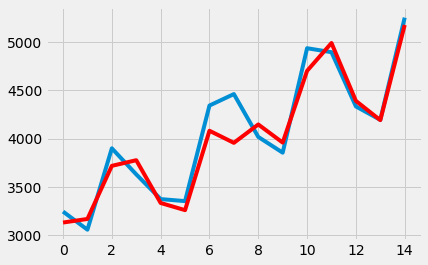

In [ ]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

A line plot is created which shows the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale

In [ ]:
df1 = pd.get_dummies(data1, columns = ['Quarter'])

In [ ]:
df1.columns = ['Sales','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4']

In [ ]:
df1.head(3)

,Sales,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,...,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4
0,1734.827000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2244.960999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2533.804993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
t= np.arange(1,43)

In [ ]:
df1['t'] = t

In [ ]:
df1['t_sq'] = df1['t']*df1['t']

In [ ]:
log_Sales=np.log(df1['Sales'])

In [ ]:
df1['log_Sales']=log_Sales

In [ ]:
train1, test1 = np.split(df1, [int(.67 *len(df1))])

In [ ]:
linear= smf.ols('Sales ~ t',data=train1).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test1['t'])))
rmselin=np.sqrt((np.mean(np.array(test1['Sales'])-np.array(predlin))**2))
rmselin

580.1224130918635

In [ ]:
quad=smf.ols('Sales~t+t_sq',data=train1).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predquad))**2))
rmsequad

783.7297975037553

In [ ]:
expo=smf.ols('log_Sales~t',data=train1).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test1['t'])))
rmseexpo=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

588.1405104900199

In [ ]:
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train1).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmseadd=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predadd))**2))
rmseadd

1869.7188209186954

In [ ]:
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmseaddlinear=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

596.1526282372298

In [ ]:
addquad=smf.ols('Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test1[['t','t_sq','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddquad))**2))
rmseaddquad

412.1144436053725

In [ ]:
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train1).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

2374.9194407954424

In [ ]:
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

5359.6879119332325

In [ ]:
mul_quad= smf.ols('log_Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test1[['t','t_sq','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

3630.56194673477

In [ ]:
output = {'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),
          'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}

In [ ]:
rmse=pd.DataFrame(output)

In [ ]:
rmse

,Model,Values
0,rmse_mul_quad,3630.561947
1,rmseadd,1869.718821
2,rmseaddlinear,596.152628
3,rmseaddquad,412.114444
4,rmseexpo,588.140510
5,rmselin,580.122413
6,rmsemul,2374.919441
7,rmsemulin,5359.687912
8,rmsequad,783.729798


Adding seasonality and quadratic trend will give the highest root mean square error and is not the better model.